# Keywords clustering using Google Search Console data (part 1/3)


Author: *Lino Uruñuela*: 

*   [www.Mecagoenlos.com](https://www.mecagoenlos.com/)
*   [Funnel**▼**Punk](https://www.funnelpunk.com/)
*   [@errioxa](https://twitter.com/Errioxa)

Este código es parte del artículo 
[Agrupación - Clustering de keywords SEO en Google Search Console](https://www.mecagoenlos.com/Posicionamiento/matriz-de-keywords-seo.php)



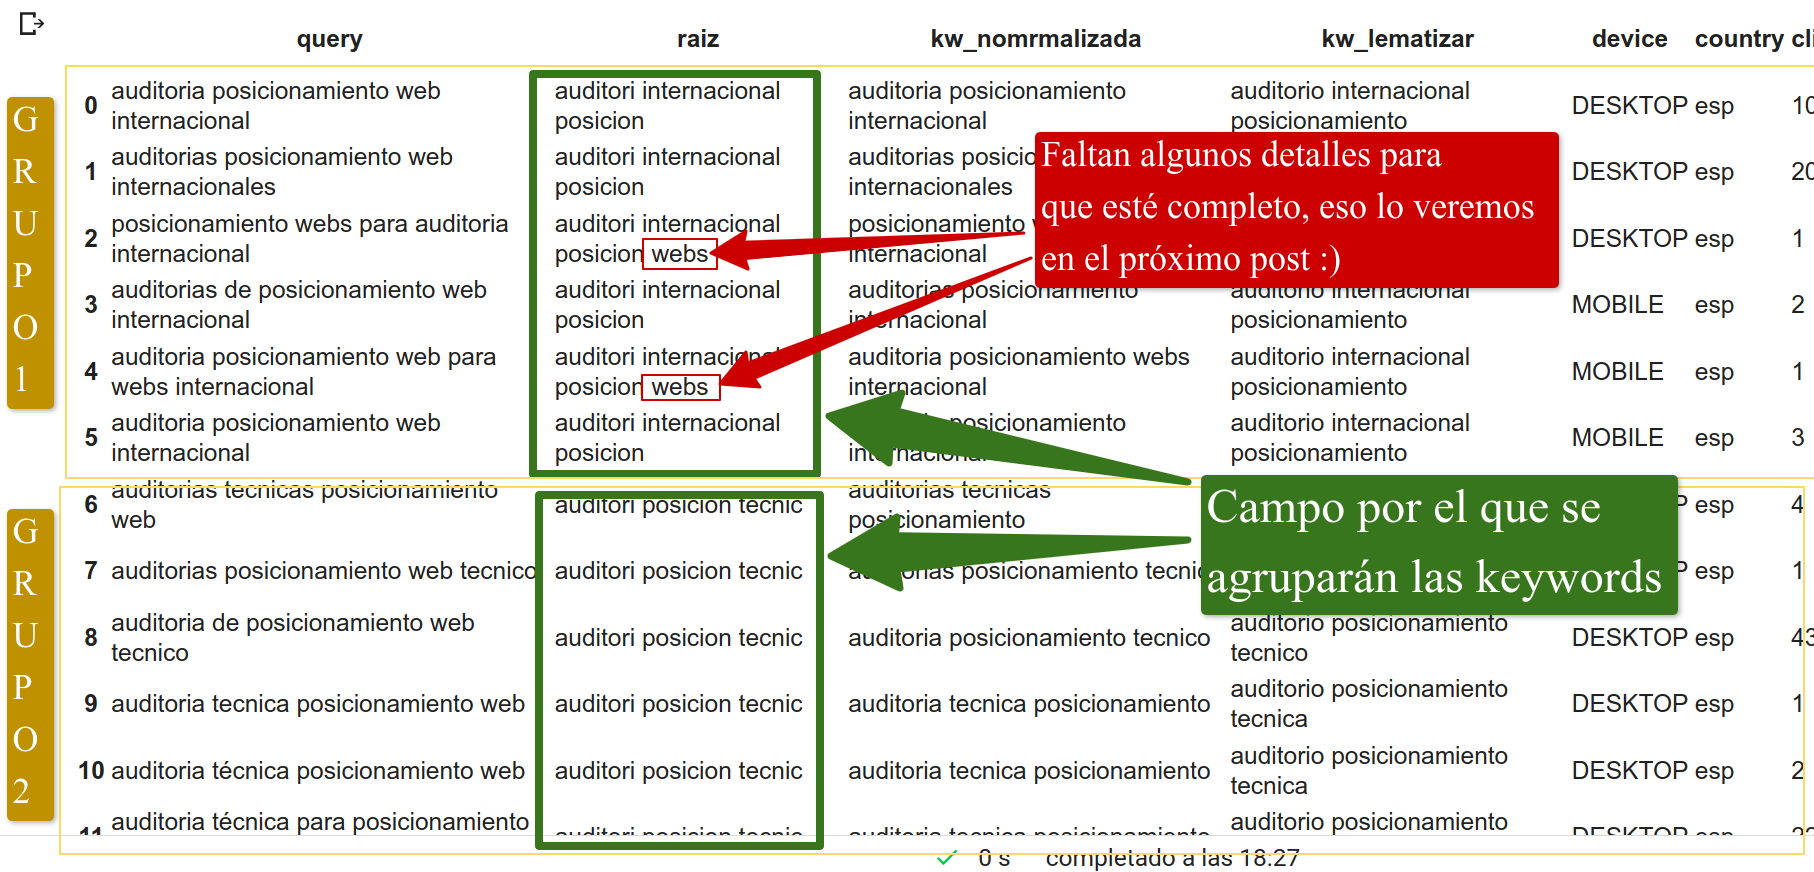



# Qué necesitarás:



Para ejecutar este script **solo necesitarás los datos de Google Searcn Console**.
Los mínimos datos que deben existir es la columna "query" dónde se encuentras las Keywords que vamos a tratar.

Mi recomendación es que exportes la mayor cantidad de datos, dado que desde Google Search Console solamente se pueden exportar un máximo de 1.000 filas os recomiendo encarecidamente que useis [Punk Export](https://www.mecagoenlos.com/tools/es/), la herramienta totalmente gratuita que desarrolle para exportar hasta 50.000 filas desde Google Search Console.

Con esta heramienta podrás exportar las siguientes columnas:
*   Query 
*   Country
*   Page
*   Device

Para poder obtener el mayor número de palabras clave posible, os recomiendo que seleccionéis "query" y "page".


Y sin más dilación vamos al código.


In [ ]:
!python -m spacy download es_core_news_sm
!pip install Unidecode

In [ ]:

#@title
import argparse
import sys
import pandas as pd
from nltk import SnowballStemmer
import spacy
import es_core_news_sm
from tqdm import tqdm
from unidecode import unidecode
import glob
import re
import requests
import json


Ahora es necesario que subas el csv con los datos de Google Search Console, puedes hacerlo sdesde [Punk Export](https://www.mecagoenlos.com/tools/es/) para que obtengas la mayor cantidad de datos posibles.



In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

df = pd.read_csv(fn)

#mostramos 10 límeas para asegurarnos de que se ha subid correctamente
df.head(10)

Y ahora vamos a procesarlo para obtener el mismo CSV pero con una columna más que se llamarán
*   raiz
*   kw_nomrmalizada
*   kw_lematizar


La columna "raiz" será la que realmente nos sea útil, pero también aadimos las otras dos para que veais la diferencia entre un método u otro.

El proceso puede tardar unos minutos, o si son muchísimos datos alguna hora! pero paciencia que terminará.

Hay una barra de progreso que nos indicará cóm avanza :)

In [ ]:
nlp = es_core_news_sm.load()
spanishstemmer=SnowballStemmer('spanish')

def normalize(text):
    text = unidecode(str(text))
    doc = nlp(text)
    words = [t.orth_ for t in doc if not t.is_punct | t.is_stop]
    lexical_tokens = [t.lower() for t in words if len(t) > 2 and t.isalpha() or re.findall("\d+", t)]
    return ' '.join(lexical_tokens)

def lematizar(text):
    lemma_text = unidecode(str(text))
    doc = nlp(lemma_text)
    lemma_words = [token.lemma_ for token in doc if not token.is_punct | token.is_stop]
    lemma_tokens = [t.lower() for t in lemma_words if len(t) > 2 and t.isalpha() or re.findall("\d+", t)]
    return ' '.join(sorted(lemma_tokens))


def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [spanishstemmer.stem(token) for token in tokens]
    return ' '.join(sorted(stemmed_tokens))

#como ejemplo de diccionario, vamos a modificar la palabra 'SEO' por 'posicionamiento web'.
#en el capítulo II veremos esto algo más a fondo
replace_dict = {
 re.compile(r'^seo(.*)'): r'posicionamiento web \1',
	re.compile(r'(.*) seo (.*)'): r'\1 posicionamiento web \2',
	re.compile(r'(.*) seo'): r'\1 posicionamiento web'}


loop = tqdm(total = len(df.index), position = 0, leave = False)

df['kw_nomrmalizada'] = ''
df['kw_lematizar'] = ''
df['raiz'] = ''
df["query"].replace(replace_dict, regex=True)
for i in df.index:
    loop.set_description("Agrupando...".format(i))

    kw = df.loc[i,'query'];
    
    df.loc[i,'kw_nomrmalizada'] = normalize(kw)
    df.loc[i,'kw_lematizar'] = lematizar(df.loc[i,'kw_nomrmalizada'])
    df.loc[i,'raiz'] = stem_sentences(df.loc[i,'kw_nomrmalizada'])
    
    print('\n\n\tkw=>\t',kw)
    print("Normalñizada=>\t", df.loc[i,'kw_nomrmalizada'])
    print("Steemeada'=>\t",df.loc[i,'raiz'])
    print("Lemmatizada'=>\t",df.loc[i,'kw_lematizar'])
    
    loop.update(1)
    
loop.close()
print('Agrupado... OK')

df.to_csv('cluster-keywords.csv', index=False, encoding='utf-8-sig')
print('Archivo kw_procesado.csv creado... OK')
files.download('cluster-keywords.csv')
print('Proceso finalizado... OK')
df.head(10)

Una vez terminado el proceso deberías ver el fichero generado que se llama "cluster-keywords.csv" 